In [1]:
%load_ext autoreload
%autoreload 2

#### Run the cell bellow, uncommented if using autogluon

In [2]:
# pip install autogluon

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from anonymeter.evaluators import InferenceEvaluator
from autogluon.tabular import TabularPredictor


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Downloading the data

For this example, we will use the famous `Adults` (more details [here](https://archive.ics.uci.edu/ml/datasets/adult)) dataset. This dataset contains aggregated census data, where every row represent a population segment. For the purpose of demonstrating `Anonymeter`, we will use this data as if each row would in fact refer to a real individual. 

The synthetic version has been generated by `CTGAN` from [SDV](https://sdv.dev/SDV/user_guides/single_table/ctgan.html), as explained in the paper accompanying this code release. For details on the generation process, e.g. regarding hyperparameters, see Section 6.2.1 of [the accompanying paper](https://petsymposium.org/popets/2023/popets-2023-0055.php)).

We pull these datasets from the [Statice](https://www.statice.ai/) public GC bucket:

In [5]:
ori = pd.read_csv(Path.home() / "projects/synthetic_data/original/adult/train.csv")
syn = pd.read_csv(Path.home() / "projects/synthetic_data/synthetic/adult/ARF.csv")
control = pd.read_csv(Path.home() / "projects/synthetic_data/original/adult/test.csv")

In [6]:
ori.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,37,Private,193106,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K
1,56,Self-emp-inc,216636,12th,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1651,40,United-States,<=50K
2,53,Private,126977,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,<=50K
3,72,Private,205343,11th,7,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
4,46,State-gov,106705,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,<=50K


As visible the dataset contains several demographic information, as well as information regarding the education, financial situation, and personal life of some tens of thousands of "individuals".

# Measuring the Inference Risk

With this new implementation we allow for the user to pass their own model in order to do the attribute inference.
The requirements for the model are:
1. It is trained on the synthetic data with the `secret` as a target.
2. It supports the ::predict(x) method

Finally, it should be passed as `ml_model=predictor` to the `InferenceEvaluator` like in the example below:
(in case we pass our own ml model and want to have the predictions for all original/control data, set sample_attacks=False)

In [7]:
columns = ori.columns[:5] # Using the first 5 columns only for this example
results = []

results_for_groups = {}

for secret in columns:
    predictor = TabularPredictor(label=secret)
    predictor.fit(
        train_data=syn,
        hyperparameters={
            'RF': {},  
        }
    )
    aux_cols = [col for col in columns if col != secret]
    
    # Needed for anonymeter (is the target categorical or numerical variable?)
    regression = True if syn[secret].dtype.kind in 'iuf' else False
    
    # Init the InferenceEvaluator
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=6000, #todo important! this parameter is obsolete if sample_attacks is False
                                   regression = regression,
                                   ml_model=predictor,
                                   sample_attacks=False) # Setting to true for this example
    # Evaluate
    evaluator.evaluate(n_jobs=-2)
    
    # Gather the results for the current group
    results_for_groups[secret] = evaluator.risk_for_groups()
    results.append((secret, evaluator.results()))

No path specified. Models will be saved in: "AutogluonModels/ag-20250515_115045"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.9.22
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:28:23 PDT 2025; root:xnu-11417.101.15~117/RELEASE_X86_64
CPU Count:          12
Memory Avail:       6.02 GB / 16.00 GB (37.6%)
Disk Space Avail:   196.96 GB / 465.63 GB (42.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accura

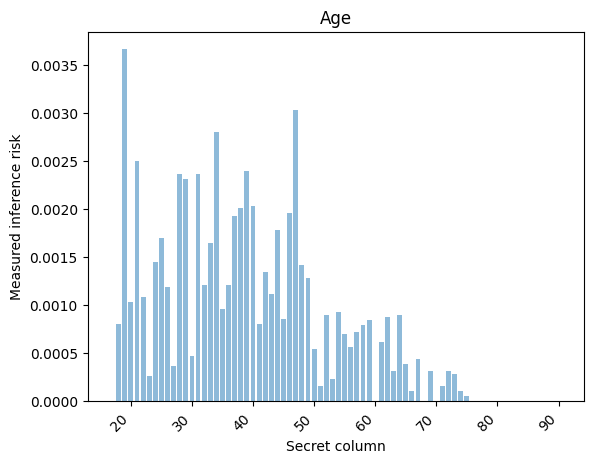

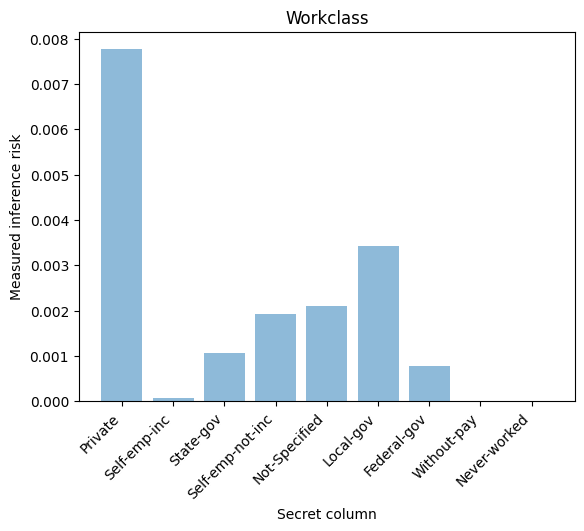

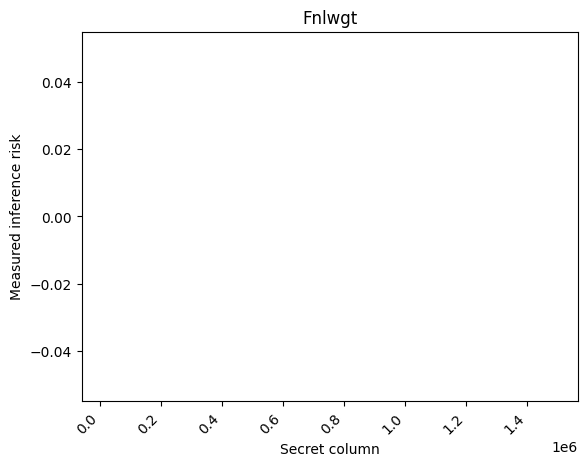

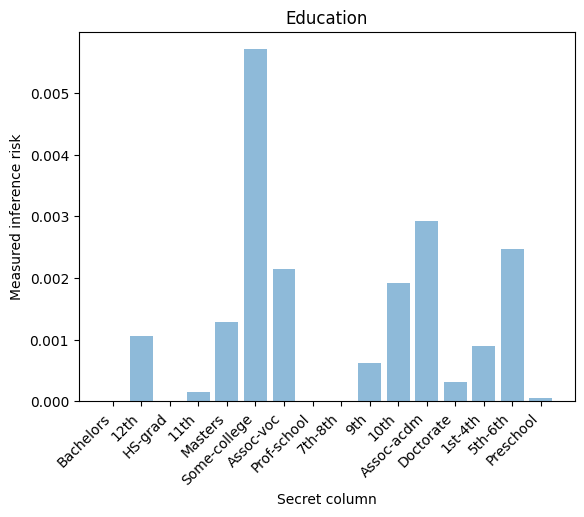

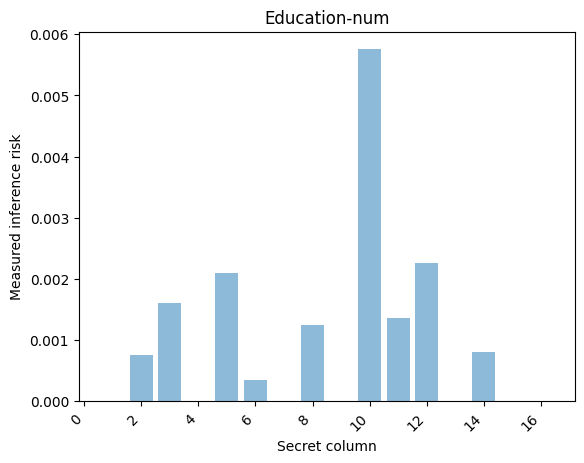

In [8]:
for secret in columns:
    curr_res = results_for_groups[secret]

    fig, ax = plt.subplots()

    risks = [res["risk"].value for _, res in curr_res.items()]
    columns = [key for key,_ in curr_res.items()]

    ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.title(secret)
    ax.set_ylabel("Measured inference risk")
    _ = ax.set_xlabel("Secret column")

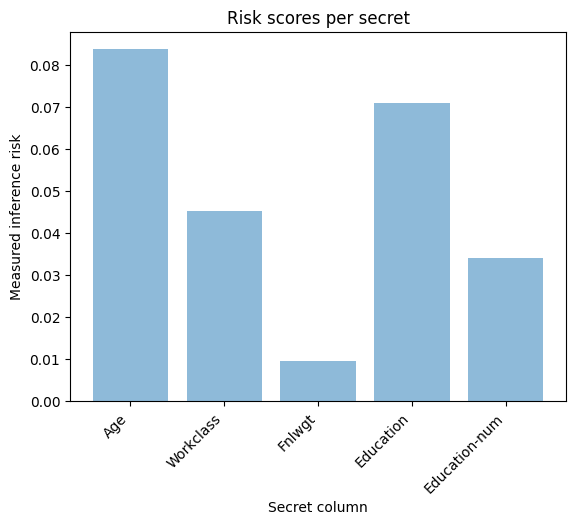

In [9]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
plt.title("Risk scores per secret")
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")